In [92]:
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%run model.py
%run betweenCompare.py

%matplotlib inline


np.random.seed(1001)

# Functions 

# Load Data

In [10]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

def loadSentimentData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, index_col=0)
    data.dropna(inplace=True)
    data.drop(['arousal_mv','valence_mv','label'], 1, inplace=True)
    data.index = data.index.astype('int64')
    
    return data

def loadUserData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, encoding="cp1252")
    data = data[['id','favourites_count','followers_count','friends_count','listed_count','statuses_count', 'label', 'default_profile', 'default_profile_image','verified']]
    data.set_index('id', inplace=True)
    
    return data

def loadTimingData(fileName):
    data = pd.read_csv(datadir + fileName, header=0)
    data.set_index('user_id', inplace=True)
    
    return data

def loadData(fileNames):
    sentiment = loadSentimentData(fileNames[0])
    account = loadUserData(fileNames[1])
    timing = loadTimingData(fileNames[2])
    data = account.join(sentiment, how='left')
    data = data.join(timing, how='left')
    
    mv_cols = (pd.isnull(data)).any()
    for each_col, each_bool in zip(mv_cols.index.values, mv_cols):
        data[each_col+'_mv'] = np.where(np.isnan(data[each_col]), 1, 0)
        col_mean = data[each_col].mean()
        data[each_col] = data[each_col].fillna(col_mean)
        
    return data
    
data = loadData(['sentiment_dist_varol_dump.csv','varol-2017-users.csv','timing.csv'])

# Feature Selection

In [84]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data.drop('label', 1), data.label, test_size=0.2, random_state=1001)

In [14]:
# DecisionTree for MI scores
dt = Model("Decision Tree", DecisionTreeClassifier(criterion='entropy'), X_train, y_train, X_test, y_test)

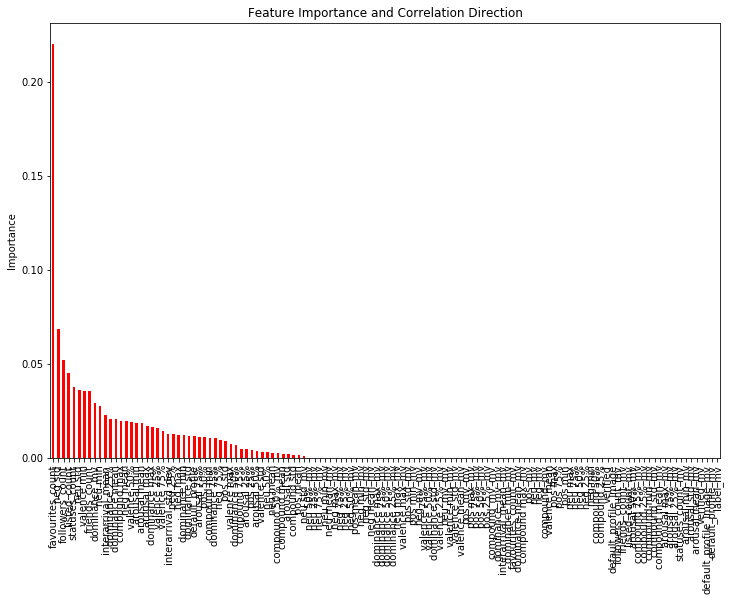

In [15]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [16]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

In [ ]:
# Baseline Logistic Regression and SVM
lr = Model("Logistic Regression", LogisticRegression(C=1e30), X_train, y_train, X_test, y_test)
svm = Model("SVM", SVC(kernel="linear"), X_train, y_train, X_test, y_test)
knn = Model("KNN", KNeighborsClassifier(35), X_train, y_train, X_test, y_test)

svm_pipeline = Pipeline(steps = [('normalize', Normalizer()),
                                 ('estimator', svm.model)])

knn_pipeline = Pipeline(steps = [('normalize', Normalizer()),
                                 ('estimator', knn.model)])

kfold = KFold(10, True)
lr_cv = cross_val_score(lr.model, X_train, y_train, cv = kfold, scoring="roc_auc")
svm_cv = cross_val_score(svm_pipeline, X_train, y_train, cv = kfold, scoring="roc_auc")
knn_cv = cross_val_score(knn_pipeline, X_train, y_train, cv = kfold, scoring="roc_auc")

In [ ]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

print("\nSVM Mean CV AUC Score: {:0.3}".format(np.mean(svm_cv))+
      "\nSVM StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(svm_cv)/len(svm_cv))))

print("\nKNN Mean CV AUC Score: {:0.3}".format(np.mean(knn_cv))+
      "\nKNN StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(knn_cv)/len(knn_cv))))

In [ ]:
# ROC Curve for single test split baseline models
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_zip = zip([preds_lr, preds_svm, preds_knn], ["LogisticRegression", "SVM", "KNN"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for Baseline Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Pipelines

In [ ]:
lr_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('estimator', LogisticRegression())])

svm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('normalize', Normalizer()),
                        ('estimator', SVC())])

gbm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('estimator', GradientBoostingClassifier())])

# GBM Tuning 

In [93]:
gbc = Model("GBC", GradientBoostingClassifier(), X_train_filt, y_train, X_test_filt, y_test)

 ## Iteration 1

Best Score: 0.859749

Best Params:  {'estimator__n_estimators': 70}


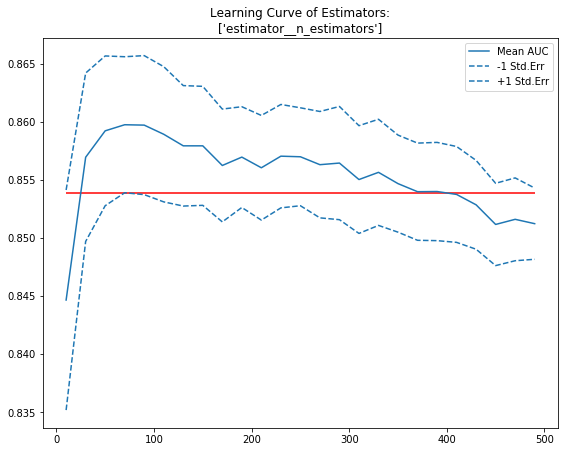

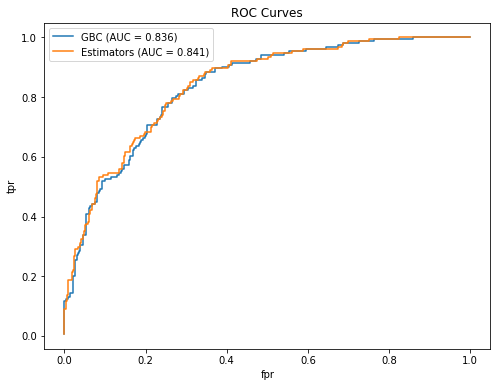

In [26]:
gbc.tuningIteration("Estimators", GradientBoostingClassifier(),
                {'estimator__n_estimators': list(range(10,500,20))}, plot = True)
gbc.withinCompare()

## Iteration 2 

Best Score: 0.860057

Best Params:  {'estimator__max_depth': 3}


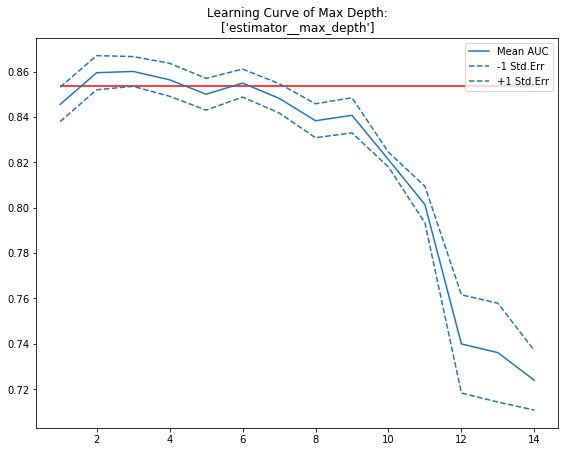

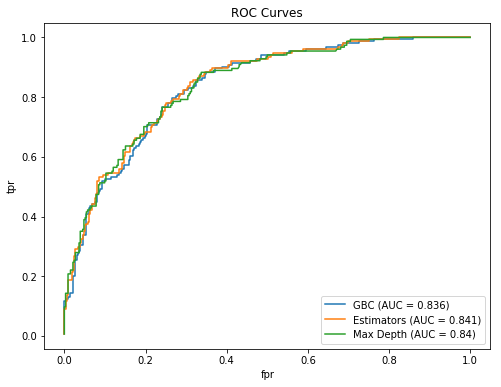

In [27]:
gbc.tuningIteration("Max Depth", GradientBoostingClassifier(n_estimators=50),
                {'estimator__max_depth': list(range(1,15))}, plot = True)
gbc.withinCompare()

## Iteration 3

Best Score: 0.860272

Best Params:  {'estimator__min_samples_leaf': 135}


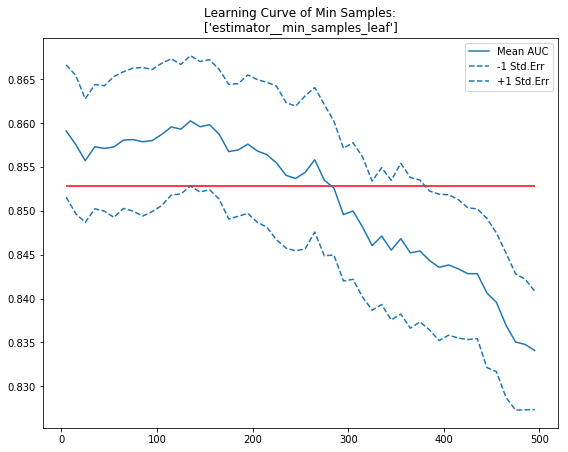

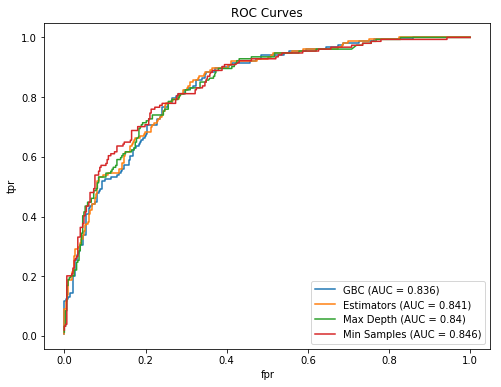

In [51]:
gbc.tuningIteration("Min Samples", GradientBoostingClassifier(n_estimators=50, max_depth=2),
                {'estimator__min_samples_leaf': list(range(5,500,10))}, plot = True)
gbc.withinCompare()

## Iteration 4

Best Score: 0.859069

Best Params:  {'estimator__max_features': 12}


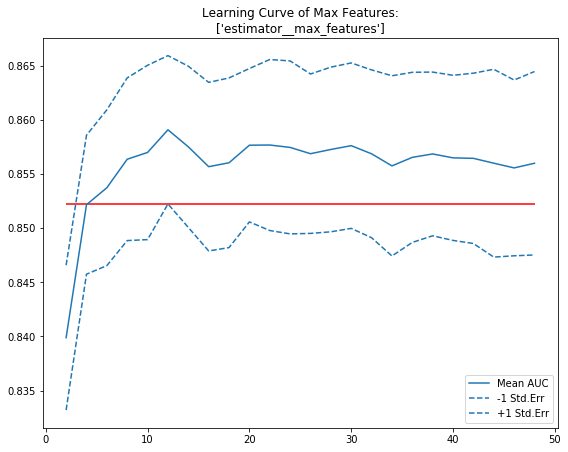

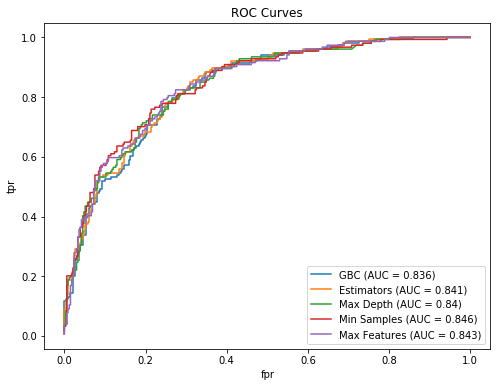

In [52]:
gbc.tuningIteration("Max Features", GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215),
                {'estimator__max_features': list(range(2,X_train_filt.shape[1],2))}, plot = True)
gbc.withinCompare()

## Iteration 5

Best Score: 0.858861

Best Params:  {'estimator__subsample': 0.90000000000000002}


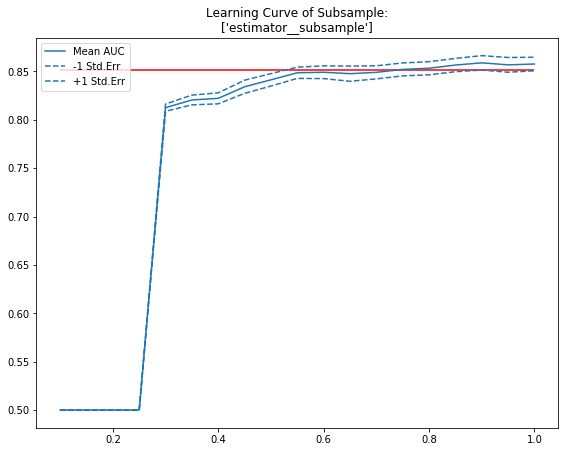

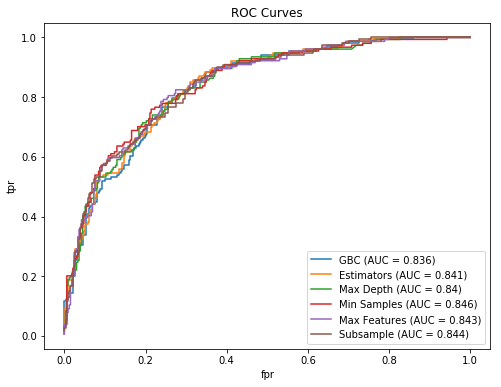

In [54]:
gbc.tuningIteration("Subsample", 
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100}, plot = True)
gbc.withinCompare()

## Interation 6 

Best Score: 0.866286

Best Params:  {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 210}


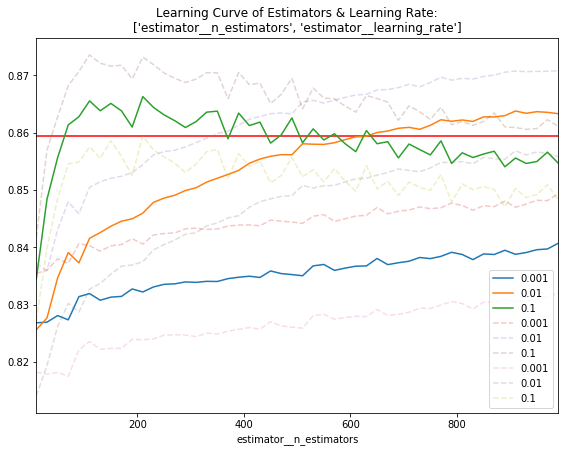

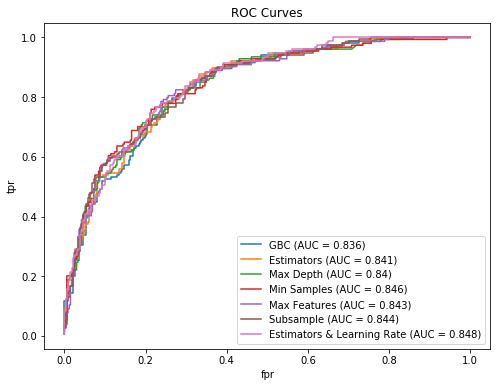

In [55]:
gbc.tuningIteration("Estimators & Learning Rate",
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85),
                {'estimator__n_estimators': list(range(10,1000,20)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]}, plot = True)
gbc.withinCompare()

## Iteration 7 

Best Score: 0.866157

Best Params:  {'estimator__n_estimators': 1700}


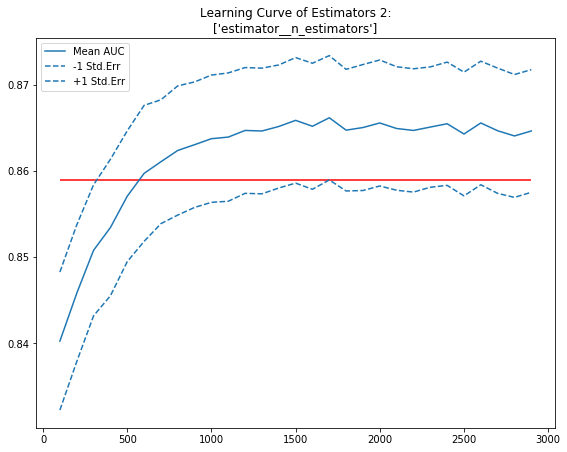

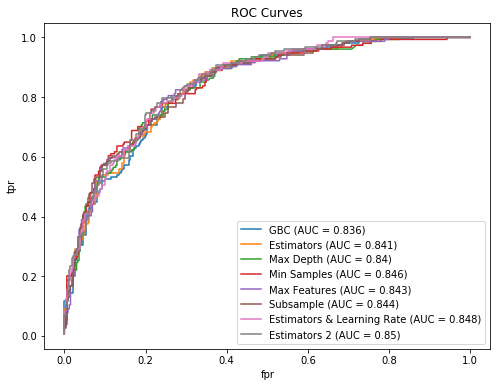

In [56]:
gbc.tuningIteration("Estimators 2",
                GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85, learning_rate=0.01),
                {'estimator__n_estimators': list(range(100,3000,100))}, plot = True)
gbc.withinCompare()

In [59]:
def betweenCompare(models):
    fig, axes = plt.subplots(1,1, figsize=(8,6))
    for model in models:
        fpr, tpr, thresholds = mt.roc_curve(model.y_test, model.best_cv.predictions[:,1])
            axes.plot(fpr, tpr, label = model.name + " (AUC = {:0.3})".format(model.best_cv.auc))
    #plot aesthetics
    plt.title("ROC Curves")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()

## Compare Results

In [ ]:
# ROC Curve for test split
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

gbm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', GradientBoostingClassifier(n_estimators=1200,max_depth=2,
                                                                        min_samples_leaf=215, max_features=14,
                                                                        subsample=0.85, learning_rate=0.01))])

gbm_pipeline_baseline = Pipeline([('variance_thresh', VarianceThreshold()),
                                  ('estimator', GradientBoostingClassifier())])


gbm_pipeline_final.fit(X_train_filt, Y_train)
gbm_pipeline_baseline.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_gbm = gbm_pipeline_final.decision_function(X_test_filt)
preds_gbm2 = gbm_pipeline_baseline.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm, preds_knn, preds_gbm, preds_gbm2],
                ["LogisticRegression", "SVM", "KNN", "GBM", "GBM-Baseline"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Brute Force Grid Search 

In [ ]:
lr_param_grid = {'estimator__C': [10**x for x in range(-8,3)]}

svm_param_grid = {'estimator__C': [10**x for x in range(-8,3)],
                  'estimator__kernel': ['linear','poly','rbf','sigmoid'],
                  'estimator__degree': [2,3,4]}

gbm_param_grid = {'estimator__learning_rate': [10**x for x in range(-8,0)],
                  'estimator__max_depth': list(range(2,16)),
                  'estimator__min_samples_leaf': [5,25,50,100,250,500],
                  'estimator__subsample': [0.25,0.5,0.75,1],
                  'estimator__n_estimators': list(range(50,500,20)),
                  'estimator__max_features': list(range(1,30,5))}

In [ ]:
lr_grid_search = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=10, scoring='roc_auc')
lr_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(lr_grid_search.best_score_))
print("Best Params: ",lr_grid_search.best_params_)

In [ ]:
svm_grid_search = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=10, scoring='roc_auc')
svm_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(svm_grid_search.best_score_))
print("Best Params: ",svm_grid_search.best_params_)

In [ ]:
gbm_grid_search = GridSearchCV(gbm_pipeline, param_grid=gbm_param_grid, cv=10, scoring='roc_auc')
gbm_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(gbm_grid_search.best_score_))
print("Best Params: ",gbm_grid_search.best_params_)

In [ ]:
# ROC Curve for single test split
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
gmm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

gbm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', GradientBoostingClassifier(learning_rate=0.1, max_depth = 20,
                                                                        min_samples_leaf=5, subsample=0.27))])

gbm_pipeline_final.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_gbm = gbm_pipeline_final.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm, preds_knn, preds_gbm], ["LogisticRegression", "SVM", "KNN", "GBM"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

Best Score: 0.860272

Best Params:  {'estimator__min_samples_leaf': 135}


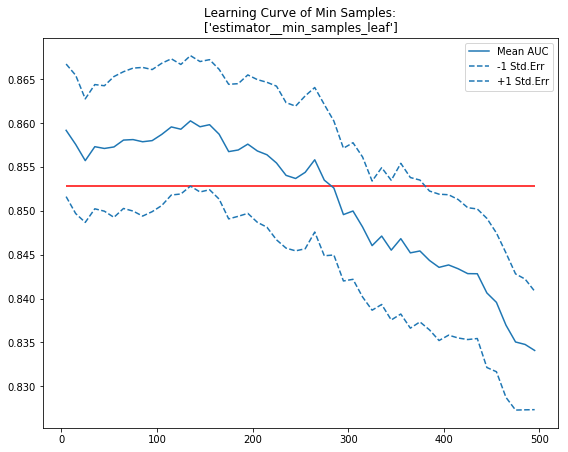

In [28]:
gbc2 = Model("GBC2", GradientBoostingClassifier(), X_train_filt, y_train, X_test_filt, y_test)

gbc2.tuningIteration("Min Samples", GradientBoostingClassifier(n_estimators=50, max_depth=2),
                {'estimator__min_samples_leaf': list(range(5,500,10))}, plot = True)

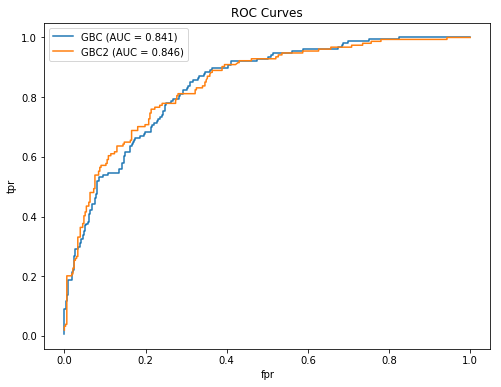

In [33]:
betweenCompare([gbc, gbc2])

In [35]:
gbc.best_cv.auc

0.84071350336410577

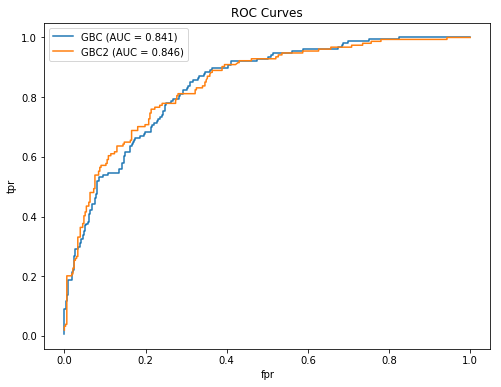

In [38]:
betweenCompare([gbc,gbc2])